<a href="https://colab.research.google.com/github/cc-ats/mlp_tutorial/blob/cw_cl/Lesson6_DeepPot-FNN_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 6: DeepPot-Smooth Edition Fitting Neural Network with Machine Learning Potentials (DeepPot-SE-FNN MLP)

$\Delta$ MLP  with PyTorch for the claisen rearrangement reaction

For this tutorial, we will be combining the Fitting Neural Network (FNN) from Lesson 1 and the DeepPot-Smooth Edition (DeepPot-SE) from Lesson 4 to train a $\Delta$ Machine Learning Potential ($\Delta$MLP) model to reproduce the energy and forces for the claisen rearrangement reaction. With a DeepPot-SE-FNN, we can utilize the properties from the local environment defined in the DeepPot-SE model for feature extraction and use the FNN for training. The goal of this model is to train with data that is from semiempirical (PM3) and DFT (B3LYP) levels of theory. The DeepPot-SE-FNN will be used to correct the semiempirical values to obtain DFT level accuracy, which is what makes it a $\Delta$MLP model.

## Defining the Reaction Coordinate and System Size

Reaction coordinate is $d_1 -d_2$ with 21 windows.

Total of 2100 frames (1 ps/window, frames are saved every 1 fs.)

<img src='https://raw.githubusercontent.com/cc-ats/mlp_class/main/Claisen_Rearrangement/img/pent-4-enal.png' width=200px>

In [1]:
%%capture
!pip install -U kora &> /dev/null
!pip install pytorch-lightning > /dev/null

!wget https://github.com/cc-ats/mlp_tutorial/raw/main/Claisen_Rearrangement/ml_qmmm.py
!wget https://github.com/cc-ats/mlp_tutorial/raw/main/Claisen_Rearrangement/img/claisen.mp4 &> /dev/null

In [2]:
from kora.drive import upload_public
url = upload_public('claisen.mp4')
# then display it
from IPython.display import HTML

HTML(f"""<video src={url} width=300 controls/>""")

## Import Data from GitHub (mlp_tutorial) and Install PyTorch Lightning.

Files from GitHub:
- **qm_coord.npy** (2100, 14, 3)
- **qm_elem.txt** ([8, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1])
- PM3
    - **energy_sqm.npy** (2100,)
    - **qm_grad_sqm.npy** (2100, 14, 3)

- B3LYP/6-31+G*
    - **energy.npy**  (2100,)
    - **qm_grad.npy** (2100, 14, 3)


- ml_qmmm.py (Feature and Fitting Neural Networks)

## Import Libraries

- math, typing (Sequence, Tuple)

- Torch (nn, nn.functional, Tensor. TensorDataset, DataLoader, random_split)

- PyTorch Lightning (loggers)

- ml_qmmm (Feature, Fitting)

In [3]:
import math
from typing import Sequence, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

from torch.utils.data import TensorDataset, DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers

import ml_qmmm
from ml_qmmm import Feature, Fitting

## The DeepPot Class

We define the DeepPot class to extract features from a data set using local environment propertiess for training a neural network model. 

In [4]:
class DeepPot(pl.LightningModule):
    def __init__(self, descriptor: nn.Module, fitting_net: nn.Module, learning_rate=5e-4) -> None:
        super().__init__()
        self.descriptor = descriptor
        self.fitting_net = fitting_net
        self.learning_rate = learning_rate

    def forward(self, coords: torch.Tensor, atom_types: torch.Tensor):
        coords.requires_grad_()
        descriptors = self.descriptor(coords, atom_types)
        atomic_energies = self.fitting_net((descriptors, atom_types))
        energy = torch.unbind(torch.sum(atomic_energies, dim=1))
        gradient, = torch.autograd.grad(energy, [coords], create_graph=True)
        return torch.hstack(energy), gradient

    def training_step(self, batch, batch_idx):
        qm_coord, atom_types, energy, gradient = batch
        ene_pred, grad_pred = self(qm_coord, atom_types[0])
        ene_loss = F.mse_loss(ene_pred, energy)
        grad_loss = F.mse_loss(grad_pred, gradient)

        lr = self.optimizers().optimizer.param_groups[0]['lr']
        start_lr = self.optimizers().optimizer.param_groups[0]['initial_lr']
        w_ene = 1
        w_grad = 1 + 99 * (lr / start_lr)

        loss = w_ene / (w_ene + w_grad) * ene_loss + w_grad / (w_ene + w_grad) * grad_loss
        self.log('train_loss', loss)
        self.log('l2_trn', torch.sqrt(loss))
        self.log('l2_e_trn', torch.sqrt(ene_loss))
        self.log('l2_f_trn', torch.sqrt(grad_loss))
        return loss

    def validation_step(self, batch, batch_idx):
        torch.set_grad_enabled(True)
        qm_coord, atom_types, energy, gradient = batch
        ene_pred, grad_pred = self(qm_coord, atom_types[0])
        ene_loss = F.mse_loss(ene_pred, energy)
        grad_loss = F.mse_loss(grad_pred, gradient)

        lr = self.optimizers().optimizer.param_groups[0]['lr']
        start_lr = self.optimizers().optimizer.param_groups[0]['initial_lr']
        w_ene = 1
        w_grad = 1 + 99 * (lr / start_lr)

        loss = w_ene / (w_ene + w_grad) * ene_loss + w_grad / (w_ene + w_grad) * grad_loss
        self.log('val_loss', loss)
        self.log('l2_tst', torch.sqrt(loss))
        self.log('l2_e_tst', torch.sqrt(ene_loss))
        self.log('l2_f_tst', torch.sqrt(grad_loss))
        self.log('lr', lr)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = {'scheduler': torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95),
                     'interval': 'epoch',
                     'frequency': 10,
                    }
        return [optimizer], [scheduler]

## Importing Data and Feature Extraction

We can load in our semiempirical and DFT data, which will be used by the DeepPot model for feature extraction. 


In [5]:
%%capture
import numpy as np

ds = np.DataSource(None)
qm_coord = np.array(np.load(ds.open("https://github.com/cc-ats/mlp_tutorial/raw/main/Claisen_Rearrangement/qm_coord.npy", "rb")), dtype="float32")
atom_types = np.loadtxt(ds.open("https://github.com/cc-ats/mlp_tutorial/raw/main/Claisen_Rearrangement/qm_elem.txt", "r"), dtype=int)
elems = np.unique(atom_types).tolist()
atom_types = np.array([[elems.index(i) for i in atom_types]])
atom_types = atom_types.repeat(len(qm_coord), axis=0)

energy = np.array((np.load(ds.open("https://github.com/cc-ats/mlp_tutorial/raw/main/Claisen_Rearrangement/energy.npy", "rb")) - np.load(ds.open("https://github.com/cc-ats/mlp_tutorial/raw/main/Claisen_Rearrangement/energy_sqm.npy", "rb"))) * 27.2114 * 23.061, dtype="float32")
energy = energy - energy.mean()
qm_gradient = np.array((np.load(ds.open("https://github.com/cc-ats/mlp_tutorial/raw/main/Claisen_Rearrangement/qm_grad.npy", "rb")) - np.load(ds.open("https://github.com/cc-ats/mlp_tutorial/raw/main/Claisen_Rearrangement/qm_grad_sqm.npy", "rb"))) * 27.2114 * 23.061 / 0.529177249, dtype="float32")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

qm_coord = torch.from_numpy(qm_coord).to(device)
atom_types = torch.from_numpy(atom_types).to(device)
energy = torch.from_numpy(energy).to(device)
qm_gradient = torch.from_numpy(qm_gradient).to(device)

In [6]:
pl.seed_everything(2)
dataset = TensorDataset(qm_coord, atom_types, energy, qm_gradient)
train, val = random_split(dataset, [2016, 84])
train_loader = DataLoader(train, batch_size=32)
val_loader = DataLoader(val, batch_size=32)

INFO:lightning_fabric.utilities.seed:Global seed set to 2


## Training the Neural Network

Now we begin training our NN using the training and validation datasets. 


In [7]:
%%capture
%%time
pl.seed_everything(2)
descriptor = Feature(3, neuron=[25, 50, 100], axis_neuron=4)
fitting_net = Fitting(3, descriptor.output_length)
model = DeepPot(descriptor, fitting_net, learning_rate=5e-4)
csv_logger = pl_loggers.CSVLogger('logs_csv/')
trainer = pl.Trainer(max_epochs=500, logger=csv_logger, log_every_n_steps=20, accelerator='auto')
trainer.fit(model, train_loader, val_loader)
model.to(device)

INFO:lightning_fabric.utilities.seed:Global seed set to 2
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type    | Params
----------------------------------------
0 | descriptor  | Feature | 58.1 K
1 | fitting_net | Fitting | 636 K 
----------------------------------------
694 K     Trainable params
0         Non-trainable params
694 K     Total params
2.778     Total estimated model params size (MB)
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=500` reached.


## Saving the Model to a PyTorch File

The following files are saved:

**1) model.pt**
- torch.save saves tensors to model.pt

**2) model_script.pt**
- torch.jit.save attempts to preserve the behavior of some operators across PyTorch versions.

Previously saved models can be loaded with:
- model.load_state_dict(torch.load(' **1)** '))
- torch.jit.load(' **2)** ')

In [8]:
torch.save(model.state_dict(), 'model.pt')
torch.jit.save(model.to_torchscript(), "model_script.pt")

# To load models:
# model.load_state_dict(torch.load('model_diff.pt'))
# model = torch.jit.load('model_diff_script.pt')

In [9]:
ene_pred, grad_pred = model(qm_coord, atom_types[0])

## Plotting RMSD for $\Delta$MLP Energy and Forces

RMSD for predicted and reference energy and forces are calculated and displayed below. 

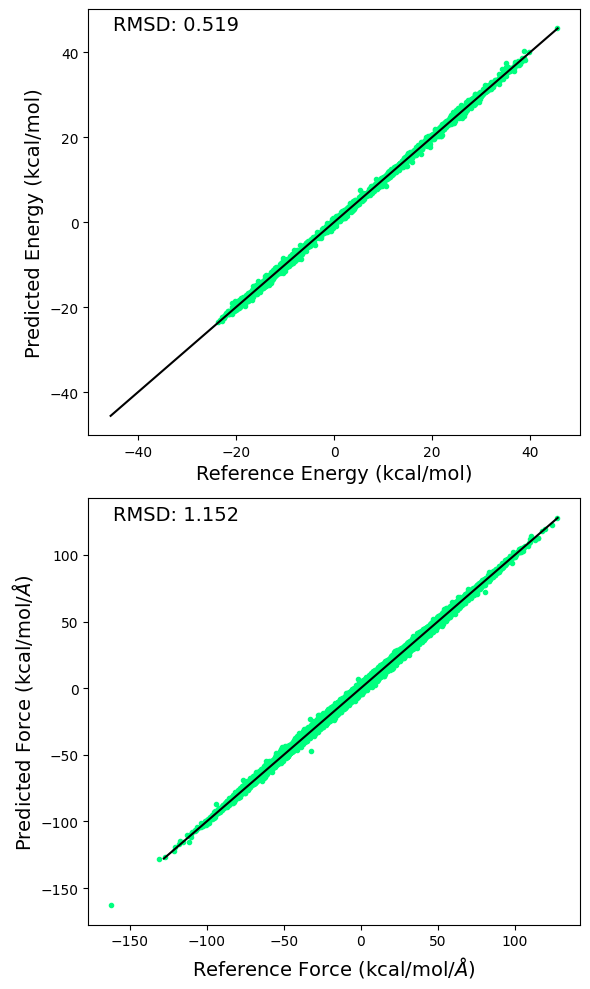

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,figsize=(6,10))

e1 = energy.cpu().detach().numpy() + np.load(ds.open("https://github.com/cc-ats/mlp_tutorial/raw/main/Claisen_Rearrangement/energy_sqm.npy","rb")) * 27.2114 * 23.061
e2 = ene_pred.cpu().detach().numpy() + np.load(ds.open("https://github.com/cc-ats/mlp_tutorial/raw/main/Claisen_Rearrangement/energy_sqm.npy","rb")) * 27.2114 * 23.061
ax[0].plot(e1, e2, linestyle='none', marker='.', color='springgreen')
ax[0].plot([np.max(np.concatenate((e1,e2))), -np.max(np.concatenate((e1,e2)))], [np.max(np.concatenate((e1,e2))), -np.max(np.concatenate((e1,e2)))], color="k", linewidth=1.5)
ax[0].set_xlabel("Reference Energy (kcal/mol)", size=14)
ax[0].set_ylabel("Predicted Energy (kcal/mol)", size=14)
ax[0].annotate('RMSD: %.3f' % np.sqrt(np.mean((e1 - e2)**2)), xy=(0.05, 0.95), xycoords='axes fraction', size=14)

f1 = -qm_gradient.cpu().detach().numpy().reshape(-1) - np.load(ds.open("https://github.com/cc-ats/mlp_tutorial/raw/main/Claisen_Rearrangement/qm_grad_sqm.npy","rb")).reshape(-1) * 27.2114 * 23.061 / 0.529177249
f2 = -grad_pred.cpu().detach().numpy().reshape(-1) - np.load(ds.open("https://github.com/cc-ats/mlp_tutorial/raw/main/Claisen_Rearrangement/qm_grad_sqm.npy","rb")).reshape(-1) * 27.2114 * 23.061 / 0.529177249

ax[1].plot(f1, f2, linestyle='none', marker='.', color='springgreen')
ax[1].plot([-np.abs(np.max(np.concatenate((f1,f2)))), np.max(np.concatenate((f1,f2)))], [-np.max(np.concatenate((f1,f2))), np.max(np.concatenate((f1,f2)))], color="k", linewidth=1.5)
ax[1].set_xlabel(r'Reference Force (kcal/mol/$\AA$)', size=14)
ax[1].set_ylabel(r'Predicted Force (kcal/mol/$\AA$)', size=14)
ax[1].annotate('RMSD: %.3f' % np.sqrt(np.mean((f1 - f2)**2)), xy=(0.05, 0.95), xycoords='axes fraction', size=14)

plt.tight_layout()
plt.savefig('rmsd.png', dpi=300)

## The Model Weights and Biases Dictionary

This cell prints the size of the weights and biases used in the trained model for reference.

In [11]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
descriptor.local_embedding.0.weight 	 torch.Size([9, 25, 1])
descriptor.local_embedding.0.bias 	 torch.Size([9, 25])
descriptor.local_embedding.1.weight 	 torch.Size([9, 50, 25])
descriptor.local_embedding.1.bias 	 torch.Size([9, 50])
descriptor.local_embedding.2.weight 	 torch.Size([9, 100, 50])
descriptor.local_embedding.2.bias 	 torch.Size([9, 100])
fitting_net.fitting_net.0.weight 	 torch.Size([3, 240, 400])
fitting_net.fitting_net.0.bias 	 torch.Size([3, 240])
fitting_net.fitting_net.1.weight 	 torch.Size([3, 240, 240])
fitting_net.fitting_net.1.bias 	 torch.Size([3, 240])
fitting_net.fitting_net.2.weight 	 torch.Size([3, 240, 240])
fitting_net.fitting_net.2.bias 	 torch.Size([3, 240])
fitting_net.fitting_net.3.weight 	 torch.Size([3, 1, 240])
fitting_net.fitting_net.3.bias 	 torch.Size([3, 1])


## Plotting Training and Validation Loss for $\Delta$MLP

The loss at each step of the training process is displayed below. 

1575
500


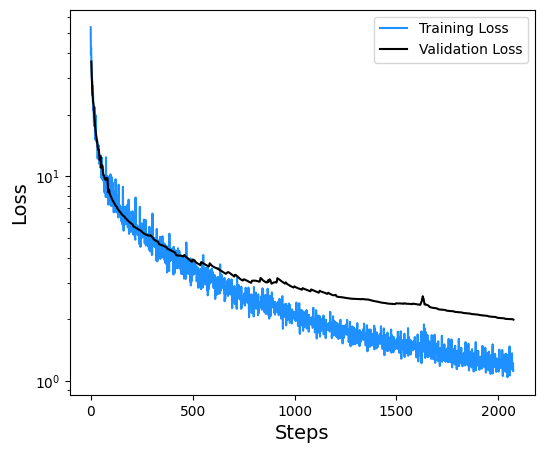

In [12]:
import pandas as pd

data = pd.read_csv('logs_csv/lightning_logs/version_0/metrics.csv')
fig, ax = plt.subplots(figsize=(6,5))
x = data['epoch'][~data['epoch'].isnull()]
y = data['train_loss'][~data['train_loss'].isnull()]
print(len(y))
plt.semilogy(y, label='Training Loss',color='dodgerblue')
y = data['val_loss'][~data['val_loss'].isnull()]
print(len(y))
plt.semilogy(y, label='Validation Loss',color='k')
plt.xlabel('Steps',size=14)
plt.ylabel('Loss',size=14)
plt.legend()
plt.savefig('loss.png', dpi=300)

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
